## Import all required libraries


In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.layers.core import  Lambda, Dense, Flatten
from keras.callbacks import EarlyStopping
from keras.layers import GlobalAveragePooling2D, Dropout, Convolution2D , MaxPooling2D, InputLayer, Resizing
from keras.applications.vgg16 import preprocess_input


## Load Train and Test data

In [11]:
# create the training & test sets, skipping the header row with [1:]
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Create numpy input data
train_full_X = (train.iloc[:,1:].values).astype('float32') # all pixel values
train_full_y = train.iloc[:,0].values.astype('int32') # only labels i.e targets digits
test_X = (test.iloc[:,1:].values).astype('float32')

# Reshape
train_full_X = train_full_X.reshape(train_full_X.shape[0], 28, 28,1)
test_X = test_X.reshape(test_X.shape[0], 28, 28,1)


# Convert the images into 3 channels
train_full_X = np.repeat(train_full_X, 3, axis=3)
test_X = np.repeat(test_X, 3, axis=3)

## Preprocessing the digit images

Feature standardization - Z-score

In [12]:
# Z-score
mean_px = train_full_X.mean().astype(np.float32)
std_px = train_full_X.std().astype(np.float32)

def standardize(x): 
    return (x-mean_px)/std_px

## Designing Convolutional Neural Network Architecture

Import pretrained model VGG16

In [13]:
vgg = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
vgg.trainable = False

Build the model

In [14]:
base = Sequential([
    InputLayer(input_shape=(28,28,3)),
    Resizing(224, 224, interpolation="bilinear"),
    vgg,
])

base.summary()

features = base.predict(preprocess_input(train_full_X))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________
 107/1875 [>.............................] - ETA: 56:20

In [ ]:
# save the features
np.save("my_base_VGG16", features)
#features = np.load("my_base_VGG16.npy")

In [ ]:
model = Sequential([
    InputLayer(input_shape=(7, 7, 512)),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(10, activation='softmax'),
])

model.summary()

Compile network

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=optimizer,
 loss='sparse_categorical_crossentropy',
 metrics=['accuracy'])

Split the data

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(train_full_X, train_full_y, test_size=0.10, random_state=42)


Run the model

In [ ]:
early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],verbose=1)

Epoch 1/200
106/106 [==============================] - 35s 321ms/step - loss: 0.9107 - accuracy: 0.7779 - val_loss: 0.2732 - val_accuracy: 0.9117
Epoch 2/200
106/106 [==============================] - 34s 325ms/step - loss: 0.2234 - accuracy: 0.9296 - val_loss: 0.1829 - val_accuracy: 0.9425
Epoch 3/200
106/106 [==============================] - 34s 323ms/step - loss: 0.1642 - accuracy: 0.9499 - val_loss: 0.1560 - val_accuracy: 0.9525
Epoch 4/200
106/106 [==============================] - 35s 326ms/step - loss: 0.1357 - accuracy: 0.9576 - val_loss: 0.1355 - val_accuracy: 0.9595
Epoch 5/200
106/106 [==============================] - 34s 321ms/step - loss: 0.1176 - accuracy: 0.9645 - val_loss: 0.1181 - val_accuracy: 0.9635
Epoch 6/200
106/106 [==============================] - 33s 314ms/step - loss: 0.1056 - accuracy: 0.9679 - val_loss: 0.1097 - val_accuracy: 0.9663
Epoch 7/200
106/106 [==============================] - 33s 313ms/step - loss: 0.0955 - accuracy: 0.9708 - val_loss: 0.0985 -

<AxesSubplot:title={'center':'Accuracy'}>

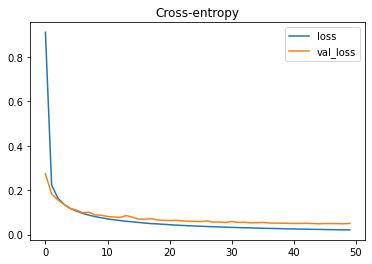

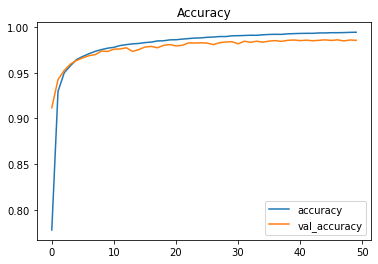

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [ ]:
model.evaluate(val_X, val_y)

188/188 [==============================] - 1s 8ms/step - loss: 0.0485 - accuracy: 0.9860


[0.04846011847257614, 0.9860000014305115]